In [24]:
import graphlab
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
import time
from copy import copy
%matplotlib inline

def norm(x):
    sum_sq=x.dot(x.T)
    norm=np.sqrt(sum_sq)
    return norm

In [25]:
wiki = graphlab.SFrame('people_wiki.gl/')
print wiki

+-------------------------------+---------------------+
|              URI              |         name        |
+-------------------------------+---------------------+
| <http://dbpedia.org/resour... |    Digby Morrell    |
| <http://dbpedia.org/resour... |    Alfred J. Lewy   |
| <http://dbpedia.org/resour... |    Harpdog Brown    |
| <http://dbpedia.org/resour... | Franz Rottensteiner |
| <http://dbpedia.org/resour... |        G-Enka       |
| <http://dbpedia.org/resour... |    Sam Henderson    |
| <http://dbpedia.org/resour... |    Aaron LaCrate    |
| <http://dbpedia.org/resour... |   Trevor Ferguson   |
| <http://dbpedia.org/resour... |     Grant Nelson    |
| <http://dbpedia.org/resour... |     Cathy Caruth    |
+-------------------------------+---------------------+
+-------------------------------+
|              text             |
+-------------------------------+
| digby morrell born 10 octo... |
| alfred j lewy aka sandy le... |
| harpdog brown is a singer ... |
| franz rott

In [27]:
wiki=wiki.add_row_number()
print wiki

+----+-------------------------------+---------------------+
| id |              URI              |         name        |
+----+-------------------------------+---------------------+
| 0  | <http://dbpedia.org/resour... |    Digby Morrell    |
| 1  | <http://dbpedia.org/resour... |    Alfred J. Lewy   |
| 2  | <http://dbpedia.org/resour... |    Harpdog Brown    |
| 3  | <http://dbpedia.org/resour... | Franz Rottensteiner |
| 4  | <http://dbpedia.org/resour... |        G-Enka       |
| 5  | <http://dbpedia.org/resour... |    Sam Henderson    |
| 6  | <http://dbpedia.org/resour... |    Aaron LaCrate    |
| 7  | <http://dbpedia.org/resour... |   Trevor Ferguson   |
| 8  | <http://dbpedia.org/resour... |     Grant Nelson    |
| 9  | <http://dbpedia.org/resour... |     Cathy Caruth    |
+----+-------------------------------+---------------------+
+-------------------------------+
|              text             |
+-------------------------------+
| digby morrell born 10 octo... |
| alfred j

In [28]:
wiki['tf_idf']=graphlab.text_analytics.tf_idf(wiki['text'])

In [29]:
print wiki

+----+-------------------------------+---------------------+
| id |              URI              |         name        |
+----+-------------------------------+---------------------+
| 0  | <http://dbpedia.org/resour... |    Digby Morrell    |
| 1  | <http://dbpedia.org/resour... |    Alfred J. Lewy   |
| 2  | <http://dbpedia.org/resour... |    Harpdog Brown    |
| 3  | <http://dbpedia.org/resour... | Franz Rottensteiner |
| 4  | <http://dbpedia.org/resour... |        G-Enka       |
| 5  | <http://dbpedia.org/resour... |    Sam Henderson    |
| 6  | <http://dbpedia.org/resour... |    Aaron LaCrate    |
| 7  | <http://dbpedia.org/resour... |   Trevor Ferguson   |
| 8  | <http://dbpedia.org/resour... |     Grant Nelson    |
| 9  | <http://dbpedia.org/resour... |     Cathy Caruth    |
+----+-------------------------------+---------------------+
+-------------------------------+-------------------------------+
|              text             |             tf_idf            |
+-------------

In [43]:
def sframe_to_scipy(column):
    x = graphlab.SFrame({'X1':column})
    x=x.add_row_number()
    x=x.stack('X1',['feature','value'])
    f=graphlab.feature_engineering.OneHotEncoder(features=['feature'])
    f.fit(x)
    x=f.transform(x)
    mapping=f['feature_encoding']
    x['feature_id']=x['encoded_features'].dict_keys().apply(lambda x: x[0])
    i=np.array(x['id'])
    j=np.array(x['feature_id'])
    v=np.array(x['value'])
    width=x['id'].max()+1
    height= x['feature_id'].max()+1
    mat=csr_matrix((v,(i,j)),shape=(width,height))
    return mat,mapping

In [44]:
start=time.time()
corpus,mapping = sframe_to_scipy(wiki['tf_idf'])
end=time.time()
print end-start

136.81515193


In [47]:
corpus

<59071x547979 sparse matrix of type '<type 'numpy.float64'>'
	with 10379283 stored elements in Compressed Sparse Row format>

In [50]:
assert corpus.shape==(59071,547979)
print "working"

working


In [51]:
def generate_random_vectors(num_vector,dim):
    return np.random.randn(dim,num_vector)

In [52]:
np.random.seed(0)
generate_random_vectors(3,5)

array([[ 1.76405235,  0.40015721,  0.97873798],
       [ 2.2408932 ,  1.86755799, -0.97727788],
       [ 0.95008842, -0.15135721, -0.10321885],
       [ 0.4105985 ,  0.14404357,  1.45427351],
       [ 0.76103773,  0.12167502,  0.44386323]])

In [53]:
np.random.seed(0)
random_vectors=generate_random_vectors(16,547979)
random_vectors.shape

(547979, 16)

In [55]:
doc = corpus[0,:]
np.array(doc.dot(random_vectors)>=0,dtype=int)

array([[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1]])

In [60]:
np.array(corpus.dot(random_vectors)>=0,dtype=int).shape

(59071, 16)

In [61]:
index_bits=(doc.dot(random_vectors)>=0)
print index_bits

[[ True  True False False False  True  True False  True  True  True False
  False  True False  True]]


In [62]:
powers_of_two = (1<<np.arange(15,-1,-1))

In [63]:
powers_of_two

array([32768, 16384,  8192,  4096,  2048,  1024,   512,   256,   128,
          64,    32,    16,     8,     4,     2,     1])

In [64]:
index_bits=corpus.dot(random_vectors)>=0
index_bits.dot(powers_of_two)

array([50917, 36265, 19365, ..., 52983, 27589, 41449])

In [73]:
def train_lsh(data,num_vector=16,seed=None):
    dim=data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors=generate_random_vectors(num_vector,dim)
    
    powers_of_two=1<<np.arange(num_vector-1,-1,-1)
    
    table={}
    
    bin_index_bits = (data.dot(random_vectors)>=0)
    
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    for data_index,bin_index in enumerate(bin_indices):
        if bin_index not in table:
            table[bin_index]=list()

        doc_ids=table[bin_index]
        doc_ids.append(data_index)
        table[bin_index]=doc_ids
    
    
    model = {
        'data':data,
        'bin_index_bits':bin_index_bits,
        'bin_indices':bin_indices,
        'table':table,
        'random_vectors':random_vectors,
        'num_vector':num_vector
    }
    
    return model

In [74]:
model = train_lsh(corpus,num_vector=16,seed=143)
table=model['table']



In [75]:
if   0 in table and table[0]   == [39583] and \
   143 in table and table[143] == [19693, 28277, 29776, 30399]:
    print 'Passed!'
else:
    print 'Check your code.'

Passed!


In [81]:
obama=wiki[wiki['name'] == 'Barack Obama']
obama

id,URI,name,text,tf_idf
35817,<http://dbpedia.org/resource/Barack_Obama> ...,Barack Obama,barack hussein obama iibrk husen bm born august ...,"{'operations':3.811771079388818, ..."


In [83]:
model['bin_indices'][35817]

50194

In [84]:
biden=wiki[wiki['name'] == 'Joe Biden']
biden

id,URI,name,text,tf_idf
24478,<http://dbpedia.org/resource/Joe_Biden> ...,Joe Biden,joseph robinette joebiden jr dosf rbnt badn ...,"{'selected':2.779911774904442, ..."


In [87]:
b = model['bin_index_bits'][24478]
o = model['bin_index_bits'][35817]

print np.array(b==o,dtype=int).sum()

14


In [88]:
print np.array(model['bin_index_bits'][22745], dtype=int) # list of 0/1's
print model['bin_indices'][22745] # integer format
model['bin_index_bits'][35817] == model['bin_index_bits'][22745]

[0 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0]
4660


array([False, False,  True, False,  True, False, False,  True,  True,
        True, False,  True,  True, False, False,  True], dtype=bool)

In [89]:
model['table'][model['bin_indices'][35817]]

[21426, 35817, 39426, 50261, 53937]

In [90]:
doc_ids = list(model['table'][model['bin_indices'][35817]])
doc_ids.remove(35817) # display documents other than Obama

docs = wiki.filter_by(values=doc_ids, column_name='id') # filter by id column
docs

id,URI,name,text,tf_idf
21426,<http://dbpedia.org/resource/Mark_Boulware> ...,Mark Boulware,mark boulware born 1948is an american diplomat ...,"{'ambassador':15.90834582606623, ..."
39426,<http://dbpedia.org/resource/John_Wells_(polit ...,John Wells (politician),sir john julius wellsborn 30 march 1925 is a ...,"{'when':1.3806055739282235, ..."
50261,<http://dbpedia.org/resource/Francis_Longstaff> ...,Francis Longstaff,francis a longstaff bornaugust 3 1956 is an ...,"{'all':1.6431112434912472, ..."
53937,<http://dbpedia.org/resource/Madurai_T._Sriniv ...,Madurai T. Srinivasan,maduraitsrinivasan is awellknown figure in the ...,"{'alarmelu':21.972990778450388, ..."


In [91]:
def cosine_distance(x, y):
    xy = x.dot(y.T)
    dist = xy/(norm(x)*norm(y))
    return 1-dist[0,0]

obama_tf_idf = corpus[35817,:]
biden_tf_idf = corpus[24478,:]

print '================= Cosine distance from Barack Obama'
print 'Barack Obama - {0:24s}: {1:f}'.format('Joe Biden',
                                             cosine_distance(obama_tf_idf, biden_tf_idf))
for doc_id in doc_ids:
    doc_tf_idf = corpus[doc_id,:]
    print 'Barack Obama - {0:24s}: {1:f}'.format(wiki[doc_id]['name'],
                                                 cosine_distance(obama_tf_idf, doc_tf_idf))

================= Cosine distance from Barack Obama
Barack Obama - Joe Biden               : 0.703139
Barack Obama - Mark Boulware           : 0.950867
Barack Obama - John Wells (politician) : 0.975966
Barack Obama - Francis Longstaff       : 0.978256
Barack Obama - Madurai T. Srinivasan   : 0.993092


In [92]:
from itertools import combinations

In [93]:
num_vector=16
search_radius=3

for diff in combinations(range(num_vector),search_radius):
    print diff

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 1, 5)
(0, 1, 6)
(0, 1, 7)
(0, 1, 8)
(0, 1, 9)
(0, 1, 10)
(0, 1, 11)
(0, 1, 12)
(0, 1, 13)
(0, 1, 14)
(0, 1, 15)
(0, 2, 3)
(0, 2, 4)
(0, 2, 5)
(0, 2, 6)
(0, 2, 7)
(0, 2, 8)
(0, 2, 9)
(0, 2, 10)
(0, 2, 11)
(0, 2, 12)
(0, 2, 13)
(0, 2, 14)
(0, 2, 15)
(0, 3, 4)
(0, 3, 5)
(0, 3, 6)
(0, 3, 7)
(0, 3, 8)
(0, 3, 9)
(0, 3, 10)
(0, 3, 11)
(0, 3, 12)
(0, 3, 13)
(0, 3, 14)
(0, 3, 15)
(0, 4, 5)
(0, 4, 6)
(0, 4, 7)
(0, 4, 8)
(0, 4, 9)
(0, 4, 10)
(0, 4, 11)
(0, 4, 12)
(0, 4, 13)
(0, 4, 14)
(0, 4, 15)
(0, 5, 6)
(0, 5, 7)
(0, 5, 8)
(0, 5, 9)
(0, 5, 10)
(0, 5, 11)
(0, 5, 12)
(0, 5, 13)
(0, 5, 14)
(0, 5, 15)
(0, 6, 7)
(0, 6, 8)
(0, 6, 9)
(0, 6, 10)
(0, 6, 11)
(0, 6, 12)
(0, 6, 13)
(0, 6, 14)
(0, 6, 15)
(0, 7, 8)
(0, 7, 9)
(0, 7, 10)
(0, 7, 11)
(0, 7, 12)
(0, 7, 13)
(0, 7, 14)
(0, 7, 15)
(0, 8, 9)
(0, 8, 10)
(0, 8, 11)
(0, 8, 12)
(0, 8, 13)
(0, 8, 14)
(0, 8, 15)
(0, 9, 10)
(0, 9, 11)
(0, 9, 12)
(0, 9, 13)
(0, 9, 14)
(0, 9, 15)
(0, 10, 11)
(0, 10, 12)
(0, 10, 13)
(0, 10, 14

In [108]:
def search_nearby_bins(query_bin_bits, table, search_radius=2, initial_candidates=set()):
    """
    For a given query vector and trained LSH model, return all candidate neighbors for
    the query among all bins within the given search radius.
    
    Example usage
    -------------
    >>> model = train_lsh(corpus, num_vector=16, seed=143)
    >>> q = model['bin_index_bits'][0]  # vector for the first document
  
    >>> candidates = search_nearby_bins(q, model['table'])
    """
    num_vector = len(query_bin_bits)
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    # Allow the user to provide an initial set of candidates.
    candidate_set = copy(initial_candidates)
    
    for different_bits in combinations(range(num_vector), search_radius):       
        # Flip the bits (n_1,n_2,...,n_r) of the query bin to produce a new bit vector.
        ## Hint: you can iterate over a tuple like a list
        alternate_bits = copy(query_bin_bits)
        for i in different_bits:
            alternate_bits[i] = 1-alternate_bits[i]
        
        # Convert the new bit vector to an integer index
        nearby_bin = alternate_bits.dot(powers_of_two)
        
        # Fetch the list of documents belonging to the bin indexed by the new bit vector.
        # Then add those documents to candidate_set
        # Make sure that the bin exists in the table!
        # Hint: update() method for sets lets you add an entire list to the set
        if nearby_bin in table:
            candidate_set.update(table[nearby_bin])
                              
    return candidate_set

In [109]:
obama_bin_index = model['bin_index_bits'][35817] # bin index of Barack Obama
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=0)
if candidate_set == set([35817, 21426, 53937, 39426, 50261]):
    print 'Passed test'
else:
    print 'Check your code'
print 'List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261'

Passed test
List of documents in the same bin as Obama: 35817, 21426, 53937, 39426, 50261


In [110]:
candidate_set = search_nearby_bins(obama_bin_index, model['table'], search_radius=1, initial_candidates=candidate_set)
if candidate_set == set([39426, 38155, 38412, 28444, 9757, 41631, 39207, 59050, 47773, 53937, 21426, 34547,
                         23229, 55615, 39877, 27404, 33996, 21715, 50261, 21975, 33243, 58723, 35817, 45676,
                         19699, 2804, 20347]):
    print 'Passed test'
else:
    print 'Check your code'

Passed test


In [113]:
from sklearn.metrics.pairwise import pairwise_distances
def query(vec, model, k, max_search_radius):
  
    data = model['data']
    table = model['table']
    random_vectors = model['random_vectors']
    num_vector = random_vectors.shape[1]
    
    
    # Compute bin index for the query vector, in bit representation.
    bin_index_bits = (vec.dot(random_vectors) >= 0).flatten()
    
    # Search nearby bins and collect candidates
    candidate_set = set()
    for search_radius in xrange(max_search_radius+1):
        candidate_set = search_nearby_bins(bin_index_bits, table, search_radius, initial_candidates=candidate_set)
    
    # Sort candidates by their true distances from the query
    nearest_neighbors = graphlab.SFrame({'id':candidate_set})
    candidates = data[np.array(list(candidate_set)),:]
    nearest_neighbors['distance'] = pairwise_distances(candidates, vec, metric='cosine').flatten()
    
    return nearest_neighbors.topk('distance', k, reverse=True), len(candidate_set)

In [116]:
query(corpus[35817,:], model, k=10, max_search_radius=3)

(Columns:
 	id	int
 	distance	float
 
 Rows: 10
 
 Data:
 +-------+--------------------+
 |   id  |      distance      |
 +-------+--------------------+
 | 35817 | -6.66133814775e-16 |
 | 24478 |   0.703138676734   |
 | 56008 |   0.856848127628   |
 | 37199 |   0.874668698194   |
 | 40353 |   0.890034225981   |
 |  9267 |   0.898377208819   |
 | 55909 |   0.899340396322   |
 |  9165 |   0.900921029925   |
 | 57958 |   0.903003263483   |
 | 49872 |   0.909532800353   |
 +-------+--------------------+
 [10 rows x 2 columns], 727)

In [117]:
query(corpus[35817,:], model, k=10, max_search_radius=3)[0].join(wiki[['id', 'name']], on='id').sort('distance')

id,distance,name
35817,-6.66133814775e-16,Barack Obama
24478,0.703138676734,Joe Biden
56008,0.856848127628,Nathan Cullen
37199,0.874668698194,Barry Sullivan (lawyer)
40353,0.890034225981,Neil MacBride
9267,0.898377208819,Vikramaditya Khanna
55909,0.899340396322,Herman Cain
9165,0.900921029925,Raymond F. Clevenger
57958,0.903003263483,Michael J. Malbin
49872,0.909532800353,Lowell Barron


In [118]:
wiki[wiki['name']=='Barack Obama']

id,URI,name,text,tf_idf
35817,<http://dbpedia.org/resource/Barack_Obama> ...,Barack Obama,barack hussein obama iibrk husen bm born august ...,"{'operations':3.811771079388818, ..."


In [122]:
num_candidates_history = []
query_time_history = []
max_distance_from_query_history = []
min_distance_from_query_history = []
average_distance_from_query_history = []

for max_search_radius in xrange(17):
    start=time.time()
    result, num_candidates = query(corpus[35817,:], model, k=10,
                                   max_search_radius=max_search_radius)
    end=time.time()
    query_time = end-start
    
    print 'Radius:', max_search_radius
    print result.join(wiki[['id', 'name']], on='id').sort('distance')
    
    average_distance_from_query = result['distance'][1:].mean()
    print average_distance_from_query
    max_distance_from_query = result['distance'][1:].max()
    min_distance_from_query = result['distance'][1:].min()
    
    num_candidates_history.append(num_candidates)
    query_time_history.append(query_time)
    average_distance_from_query_history.append(average_distance_from_query)
    max_distance_from_query_history.append(max_distance_from_query)
    min_distance_from_query_history.append(min_distance_from_query)

Radius: 0
+-------+--------------------+-------------------------+
|   id  |      distance      |           name          |
+-------+--------------------+-------------------------+
| 35817 | -6.66133814775e-16 |       Barack Obama      |
| 21426 |   0.950866757525   |      Mark Boulware      |
| 39426 |   0.97596600411    | John Wells (politician) |
| 50261 |   0.978256163041   |    Francis Longstaff    |
| 53937 |   0.993092148424   |  Madurai T. Srinivasan  |
+-------+--------------------+-------------------------+
[5 rows x 3 columns]

0.974545268275
Radius: 1
+-------+--------------------+-------------------------------+
|   id  |      distance      |              name             |
+-------+--------------------+-------------------------------+
| 35817 | -6.66133814775e-16 |          Barack Obama         |
| 41631 |   0.947459482005   |          Binayak Sen          |
| 21426 |   0.950866757525   |         Mark Boulware         |
| 33243 |   0.951765770113   |        Janice Lachanc

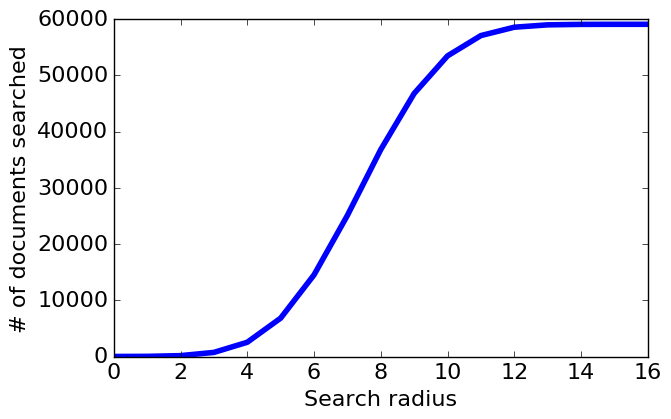

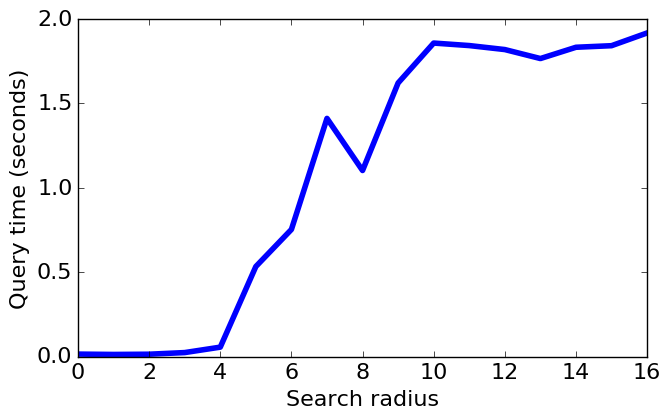

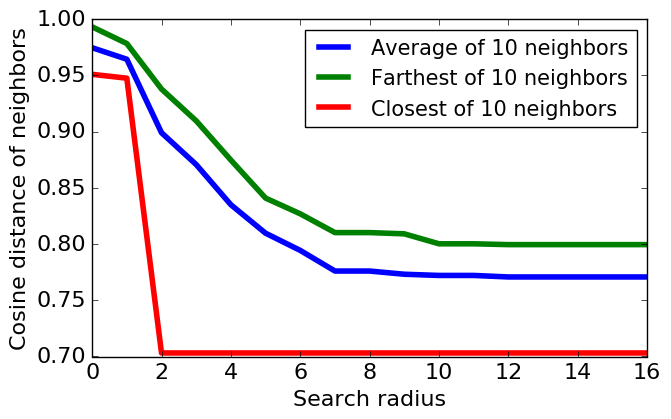

In [121]:
plt.figure(figsize=(7,4.5))
plt.plot(num_candidates_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('# of documents searched')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(query_time_history, linewidth=4)
plt.xlabel('Search radius')
plt.ylabel('Query time (seconds)')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

plt.figure(figsize=(7,4.5))
plt.plot(average_distance_from_query_history, linewidth=4, label='Average of 10 neighbors')
plt.plot(max_distance_from_query_history, linewidth=4, label='Farthest of 10 neighbors')
plt.plot(min_distance_from_query_history, linewidth=4, label='Closest of 10 neighbors')
plt.xlabel('Search radius')
plt.ylabel('Cosine distance of neighbors')
plt.legend(loc='best', prop={'size':15})
plt.rcParams.update({'font.size':16})
plt.tight_layout()